In [1]:
#import all required module
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
import warnings
from scipy import stats as stats
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler,RobustScaler
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv("E:\Machine Learning\data sets/Advertising.csv",usecols=["TV","Radio","Newspaper","Sales"])
df.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


 Dependent Feature

In [3]:
df.shape

(200, 4)

In [4]:
df.isnull().sum()  

TV           0
Radio        0
Newspaper    0
Sales        0
dtype: int64

This dataset does not have any Null value

In [5]:
df.describe()

,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


In [6]:
df.columns[:-1]

Index(['TV', 'Radio', 'Newspaper'], dtype='object')

### Distribution of the feature

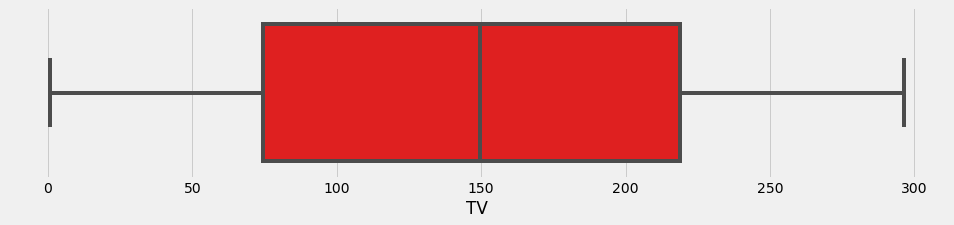

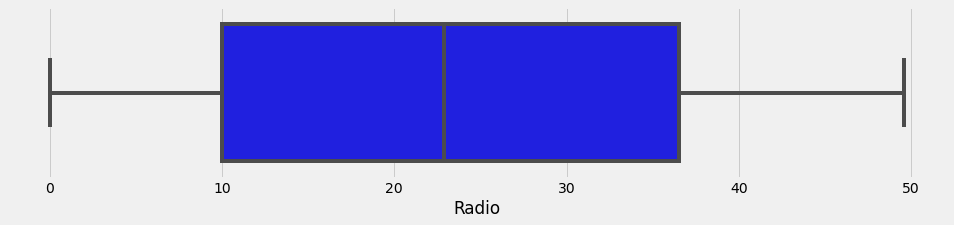

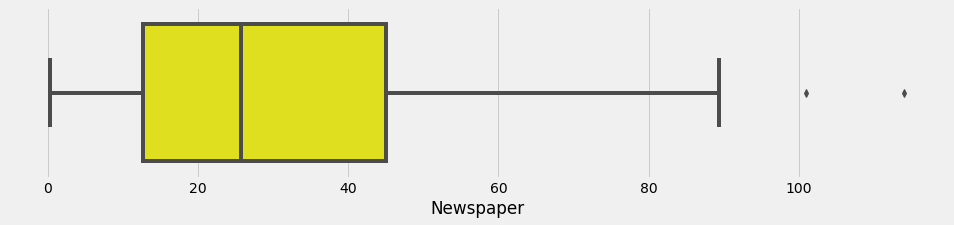

In [7]:
dict = {0:"red",1:"blue",2:"yellow"}
length = len(df.columns[:-1])
for i, j in zip(df.columns[:-1], range(length)):
    plt.figure(figsize=(15,10))
    plt.subplot(3,1,j+1)
    sns.boxplot(df[i],color=dict[j])

The news paper feature has some outliers.

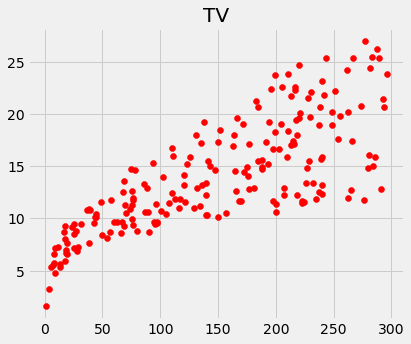

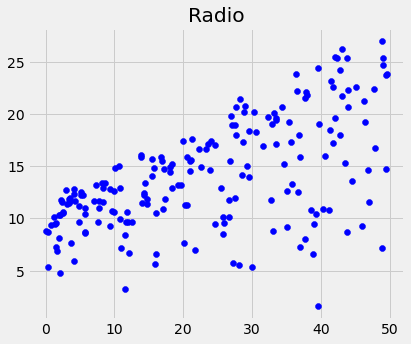

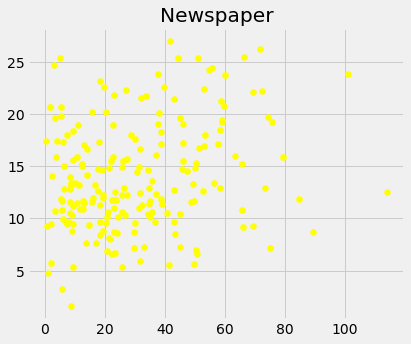

In [8]:
dict = {0:"red",1:"blue",2:"yellow"}
length = len(df.columns[:-1])
for i, j in zip(df.columns[:-1], range(length)):
    plt.figure(figsize=(6,17))
    plt.subplot(3,1,j+1)
    plt.scatter(df[i],df["Sales"],color=dict[j])
    plt.title(i)

Above Distribution says, 

1.Tv feature is co-related with Sales feature both are increasing together.

2.In Radio feature some points are co-related with Sales feature.

3.Newspaper feature distribution is not co-related with Sales feature.Data is spreaded unorder.

In [9]:
def distribution_plot(df,feature):
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    df[feature].hist(bins=20)
    plt.title(feature)
    plt.subplot(1,2,2)
    stats.probplot(df[feature],dist="norm",plot=plt)    

TV feature skewness : -0.07
Radio feature skewness : 0.094
Newspaper feature skewness : 0.895
Sales feature skewness : 0.408


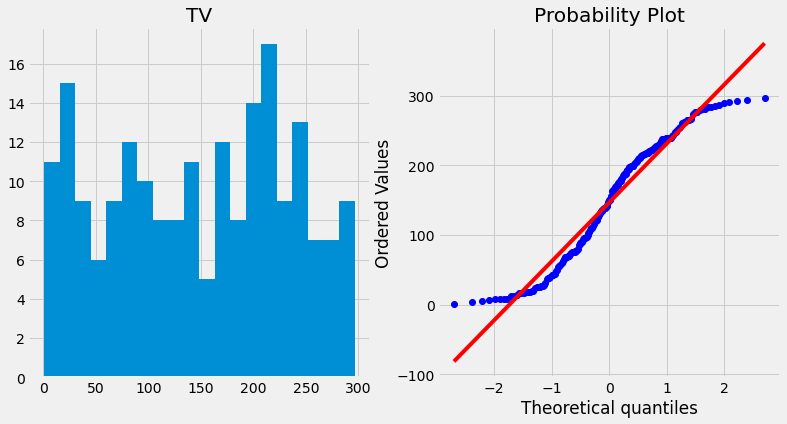

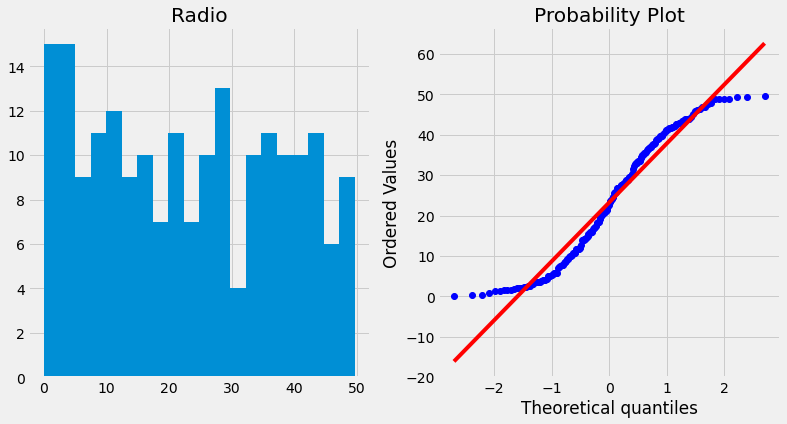

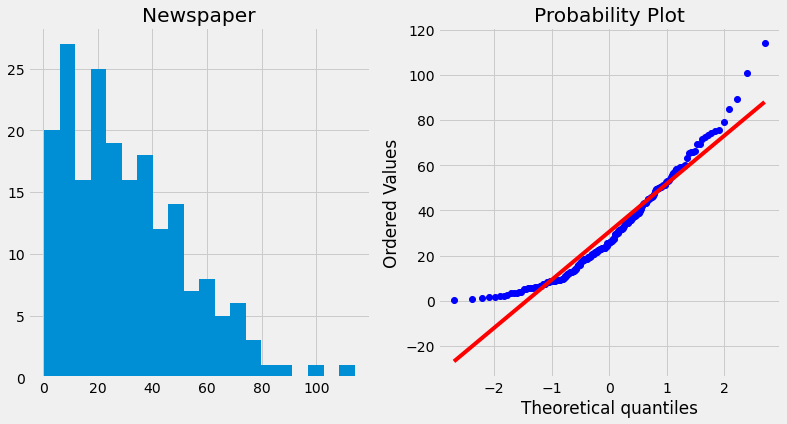

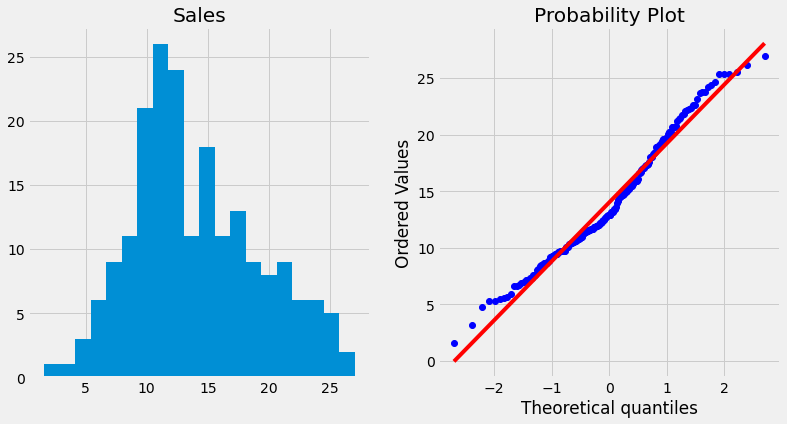

In [10]:
for i in df.columns:
    distribution_plot(df,i)
    print(f"{i} feature skewness : {np.round(df[i].skew(),3)}")

Skew = 3 * (Mean – Median) / Standard Deviation

The Above histogram and Probability diagram shows NewsPaper feature is rightside skewed.

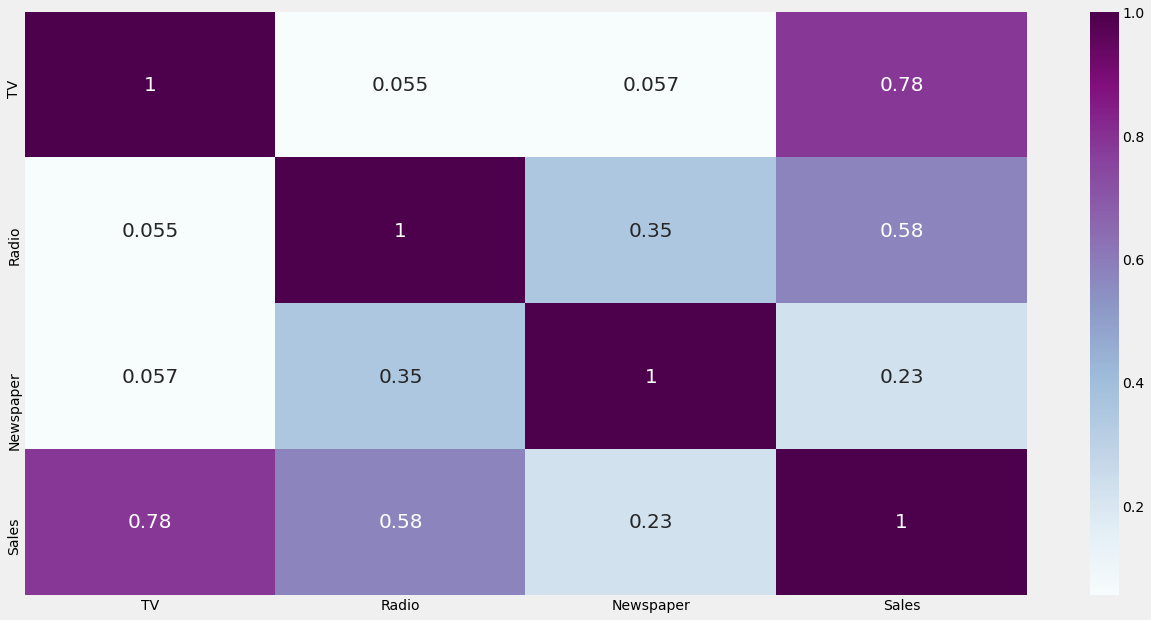

In [11]:
plt.figure(figsize=(20,10))     
sns.heatmap(df.corr(),cmap="BuPu",annot=True,annot_kws={"size":20})

Output feature is literally correlated with the Tv and Radio Feature.

## Hypothesis Testing 
### To Confirm how much features are Correlated with output feature

In [12]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr
for i in df.iloc[:,:-1]:
    stat,p = spearmanr(df[i],df["Sales"])
    print(f"p-value for {i} : {p}")
    print("")
    if p > 0.05:
        print(f"{i} feature has independent relationship with sales")
    else:
        print(f"{i} feature has dependent relationship with sales")
        
    print("")
    print("")

p-value for TV : 6.3792345734183446e-46

TV feature has dependent relationship with sales


p-value for Radio : 1.6651706375166126e-17

Radio feature has dependent relationship with sales


p-value for Newspaper : 0.005676351421789337

Newspaper feature has dependent relationship with sales




## Feature Engineering

### Guassian Transformation

 boxcox_transformation applied in Newspaper feature skewness :-0.078 


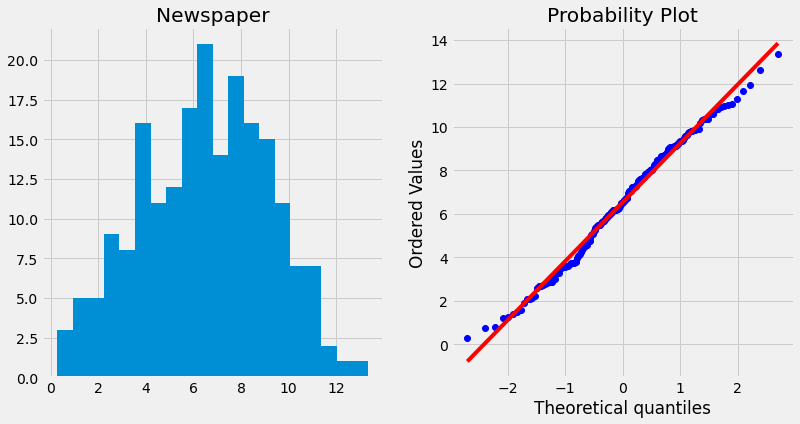

In [13]:
from scipy.special import boxcox1p
df["Newspaper"],params = stats.boxcox(df["Newspaper"]+1)
distribution_plot(df,"Newspaper")
skw = df["Newspaper"].skew()
print(f" boxcox_transformation applied in Newspaper feature skewness :{round(skw,3)} ")

I have already tried all Guassian Distribution Transformation,Boxcox transformation will give the best result compared to other transformation.

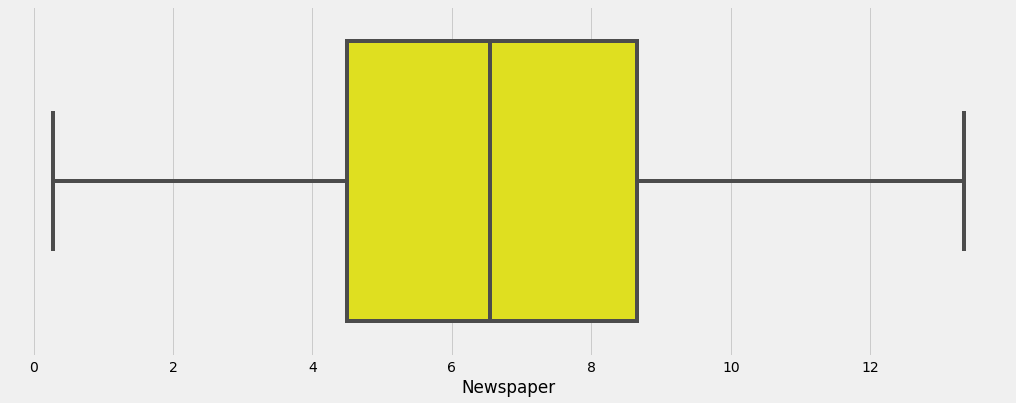

In [14]:
plt.figure(figsize=(16,6))
sns.boxplot(df["Newspaper"],color="yellow")

Outliers has been handled by Boxcox Transformation.

### Data Transformation

In [15]:
scale = StandardScaler()   
df_std = scale.fit_transform(df) 

In [16]:
rb_scale = RobustScaler()
df_rb =  rb_scale.fit_transform(df)

In [17]:
#x = df_std[:,:-1]
#y = df_std[:,-1]
x = df_rb[:,:-1]
y = df_rb[:,-1]

In [18]:
Testing_R2_Score =[]
Training_MSE = []
Testing_MSE = []
Testing_MAE = []
Residual_sum_of_squares = []
Model = []
cros_val_scr = []

In [19]:
def prediction(x_train,x_test,y_train,y_test,model,algo):        
        print(f"predictions for {algo} Algorithem")
        Model.append(algo)        
        print("Train Results: ")
        print("================")
        pre = model.predict(x_train)
        print("        Training R2 Score : {:.2f} %".format((metrics.r2_score(y_train,pre))*100))
        print("")
        print("        Training Mean Absolute Error : {:.4f} ".format((metrics.mean_absolute_error(y_train,pre))))
        print("")       
        print("        Training Mean Squared Error : {:.4f} ".format((metrics.mean_squared_error(y_train,pre))))
        print("")
        print("")
        Training_MSE.append(round(metrics.mean_squared_error(y_train,pre),3))
        print("Test Results: ")
        print("================")
        pre_t = model.predict(x_test)
        print("        Testing R2 Score : {:.2f} %".format((metrics.r2_score(y_test,pre_t))*100))
        print("")        
        print("        Testing Mean Absolute Error : {:.4f} ".format((metrics.mean_absolute_error(y_test,pre_t))))
        print("")        
        print("        Testing Mean Squared Error : {:.4f} ".format((metrics.mean_squared_error(y_test,pre_t))))
        print("")
        print("        Residual sum of squares: {:.6f}".format(np.mean(pre_t - y_test) ** 2))
        
        Testing_R2_Score.append(round((metrics.r2_score(y_test,pre_t)*100),2))
        Testing_MSE.append(round(metrics.mean_squared_error(y_test,pre_t),3))
        Residual_sum_of_squares.append(round((np.mean(pre_t - y_test) ** 2),6))
        Testing_MAE.append(round(metrics.mean_absolute_error(y_test,pre_t),3))


In [20]:
def cvs(x,y,model,algo):
    cv = cross_val_score(model,x,y,cv=5)
    print(f"Cross validation Score for {algo} : {round(cv.mean()*100,2)} %")
    cros_val_scr.append(round((cv.mean()*100),2))
               

In [21]:
color = ["#FF7300","#52D726","#FF0000","gold","#007ED6","#7CDDDD","#007ED6","#FF0000","teal",]
import random
def scatter(x_test,y_test,model,algo):
    global count
    plt.figure(figsize=(15,6))
    plt.style.use("fivethirtyeight")
    plt.scatter(y_test,model.predict(x_test),c=random.choice(color),s=80)
    plt.title(f"Prediction for {algo} Model")
    plt.xlabel('Y Test')
    plt.ylabel('Predicted Y')
    plt.show()


In [22]:
def plot(x_test,y_test,model,algo):
    plt.figure(figsize=(14,6))
    plt.style.use("seaborn-bright")
    plt.plot(y_test,label ='Test')
    plt.plot(model.predict(x_test), label = 'prediction')
    plt.title(f"Comparision between Prediction and Test data by {algo} Model")
    plt.legend()
    plt.show()

## Split Data

In [23]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=0)   

In [24]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(150, 3)
(50, 3)
(150,)
(50,)


## Model Evaluation

## Linear Regression_1

In [26]:
lr = LinearRegression()
lr.fit(x_train,y_train)
algo= "Linear Regression_1"

In [27]:
prediction(x_train,x_test,y_train,y_test,lr,algo)

predictions for Linear Regression_1 Algorithem
Train Results: 
        Training R2 Score : 90.72 %

        Training Mean Absolute Error : 0.1744 

        Training Mean Squared Error : 0.0494 


Test Results: 
        Testing R2 Score : 85.80 %

        Testing Mean Absolute Error : 0.1848 

        Testing Mean Squared Error : 0.0811 

        Residual sum of squares: 0.000263


In [28]:
cvs(x,y,lr,algo)

Cross validation Score for Linear Regression_1 : 88.74 %


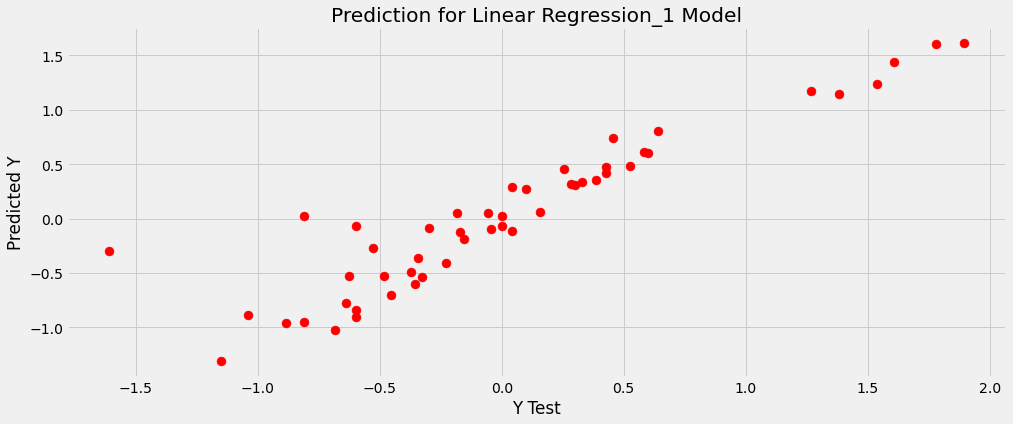

In [29]:
scatter(x_test,y_test,lr,algo)

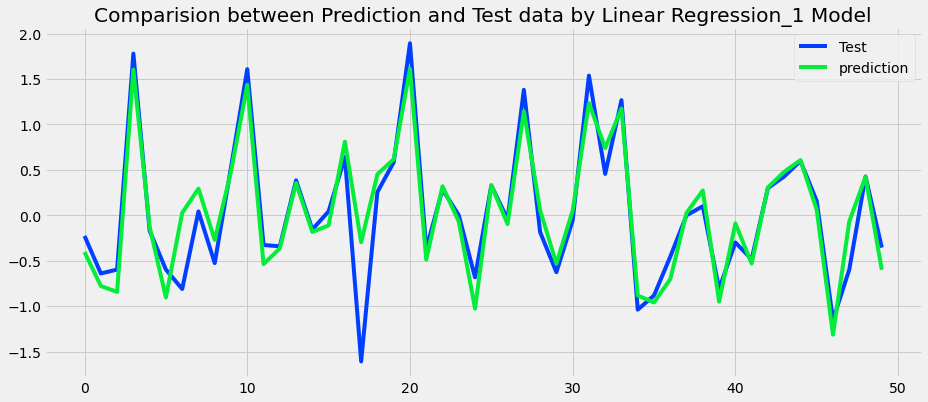

In [30]:
plot(x_test,y_test,lr,algo)

Compared to Standared Scalaer, Robust Scaler is performed well in this situation.

## Feature selection

Weights of the Features : [0.90830512 0.75246942 0.00510801]
Slope or Rotation of the Theta : 0.17056610166542002


<BarContainer object of 3 artists>

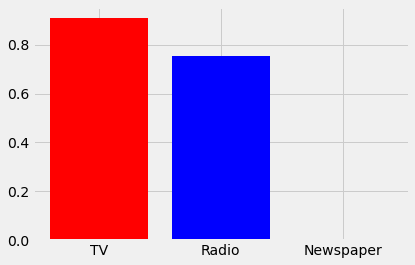

In [31]:
print(f"Weights of the Features : {lr.coef_}")
print(f"Slope or Rotation of the Theta : {lr.intercept_}")

weights = lr.coef_
plt.bar(df.columns[:-1],weights,color=["red","blue","yellow"])


Above result says,Newspaper feature importance is nearly to Zero.So we can eliminate the newspaper feature.

In [32]:
x = df_rb[:,:-2]
y = df_rb[:,-1] 

In [33]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=0)  

In [34]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(150, 2)
(50, 2)
(150,)
(50,)


## Linear Regression_2

In [36]:
lr_new = LinearRegression()
lr_new.fit(x_train,y_train)
algo= "Linear Regression_2"
prediction(x_train,x_test,y_train,y_test,lr_new,algo)

predictions for Linear Regression_2 Algorithem
Train Results: 
        Training R2 Score : 90.72 %

        Training Mean Absolute Error : 0.1744 

        Training Mean Squared Error : 0.0494 


Test Results: 
        Testing R2 Score : 85.81 %

        Testing Mean Absolute Error : 0.1843 

        Testing Mean Squared Error : 0.0810 

        Residual sum of squares: 0.000250


In [37]:
cvs(x,y,lr_new,algo)

Cross validation Score for Linear Regression_2 : 88.93 %


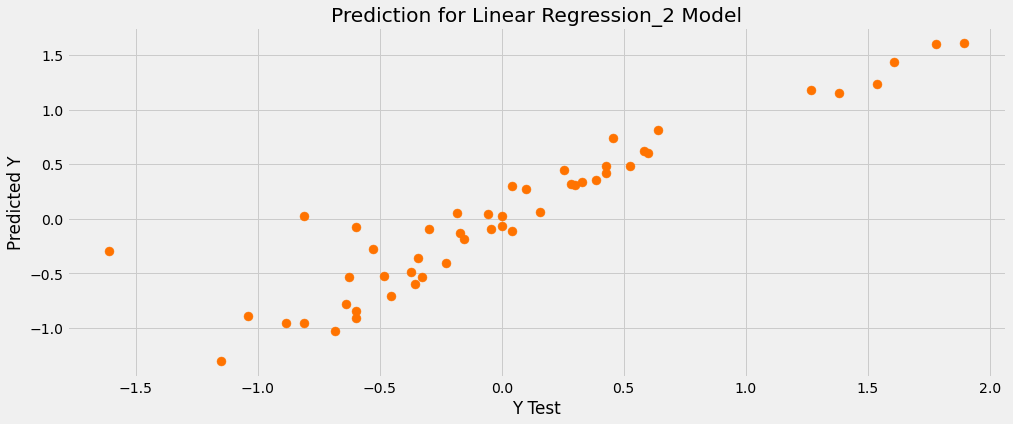

In [38]:
scatter(x_test,y_test,lr_new,algo)

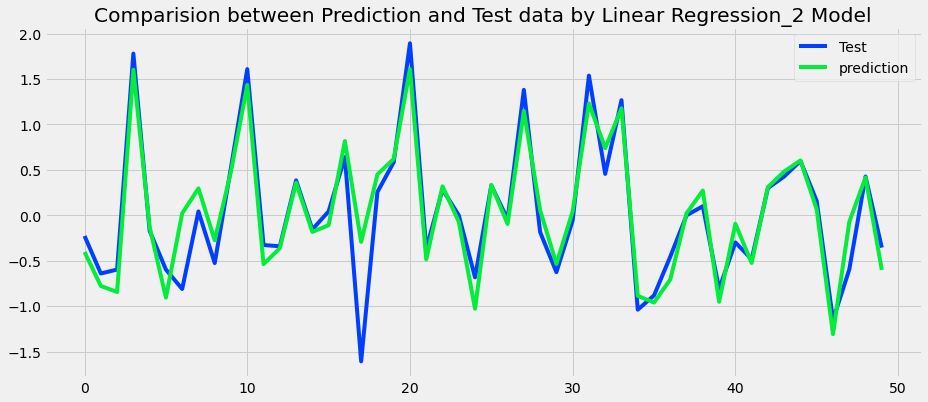

In [39]:
plot(x_test,y_test,lr_new,algo)

## Gradient Boosting Regressor

In [40]:
gbr = GradientBoostingRegressor(random_state=0)
gbr.fit(x_train,y_train)
algo= "Gradient Boosting Regressor"
prediction(x_train,x_test,y_train,y_test,gbr,algo)

predictions for Gradient Boosting Regressor Algorithem
Train Results: 
        Training R2 Score : 99.87 %

        Training Mean Absolute Error : 0.0202 

        Training Mean Squared Error : 0.0007 


Test Results: 
        Testing R2 Score : 96.68 %

        Testing Mean Absolute Error : 0.0952 

        Testing Mean Squared Error : 0.0190 

        Residual sum of squares: 0.000006


In [41]:
cvs(x,y,gbr,algo)

Cross validation Score for Gradient Boosting Regressor : 97.83 %


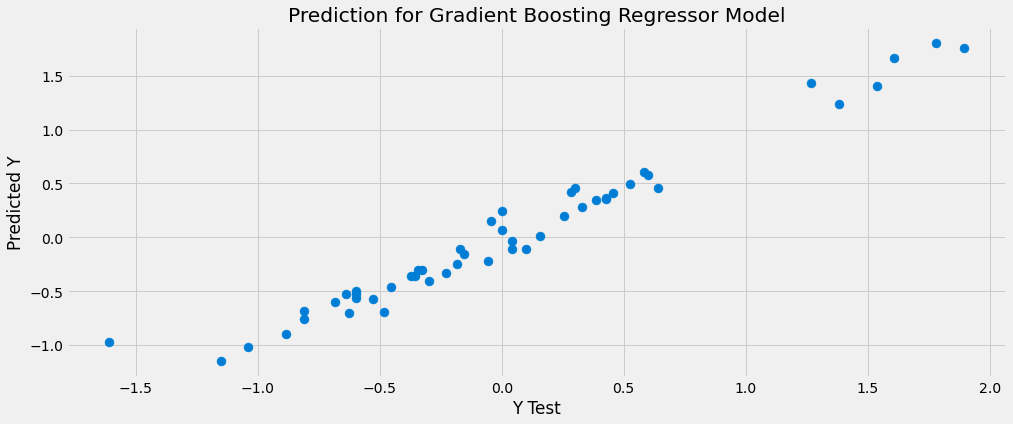

In [42]:
scatter(x_test,y_test,gbr,algo)

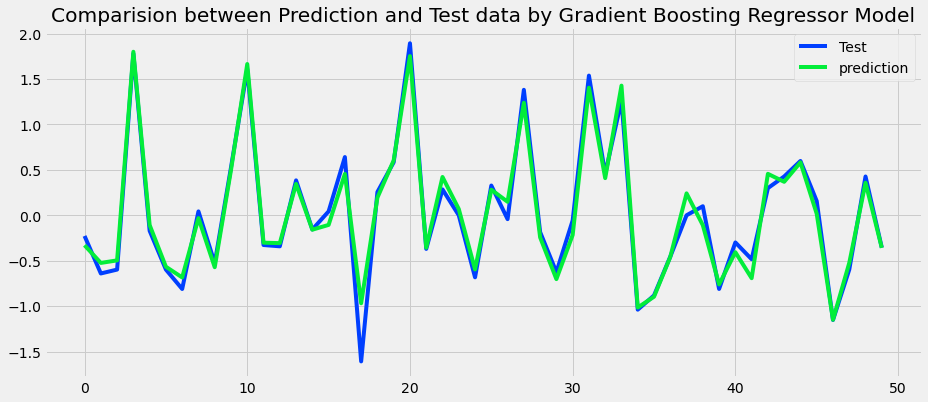

In [43]:
plot(x_test,y_test,gbr,algo)

## Ada Boost Regressor

In [44]:
abr = AdaBoostRegressor(random_state=0)
abr.fit(x_train,y_train)
algo= "Ada Boost Regressor"
prediction(x_train,x_test,y_train,y_test,abr,algo)

predictions for Ada Boost Regressor Algorithem
Train Results: 
        Training R2 Score : 97.96 %

        Training Mean Absolute Error : 0.0842 

        Training Mean Squared Error : 0.0109 


Test Results: 
        Testing R2 Score : 95.03 %

        Testing Mean Absolute Error : 0.1342 

        Testing Mean Squared Error : 0.0284 

        Residual sum of squares: 0.000315


In [45]:
cvs(x,y,abr,algo)

Cross validation Score for Ada Boost Regressor : 95.1 %


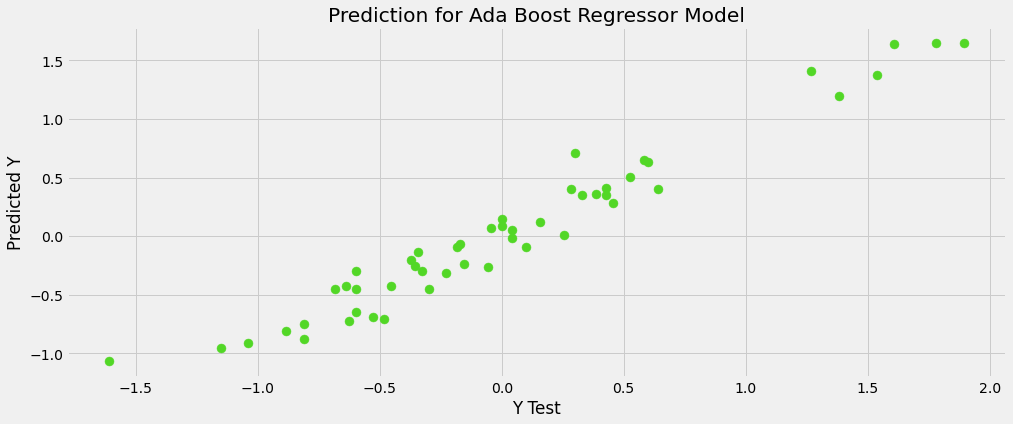

In [46]:
scatter(x_test,y_test,abr,algo)

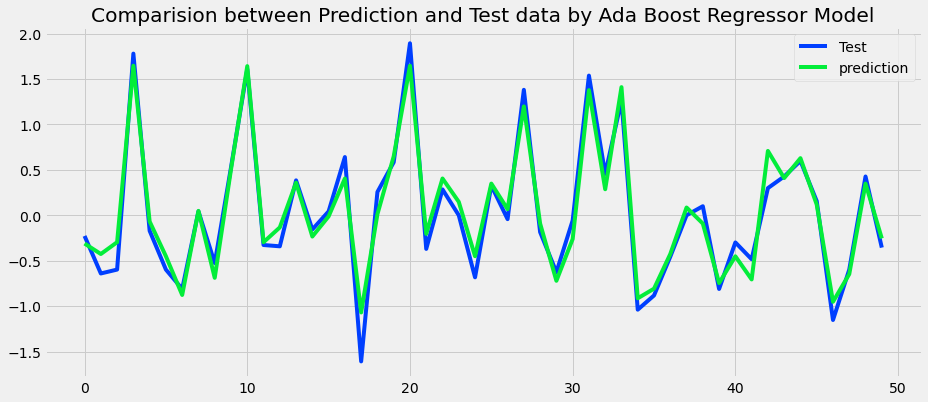

In [47]:
plot(x_test,y_test,abr,algo)

## Random Forest Regressor

In [48]:
rfr = RandomForestRegressor(random_state=0)
rfr.fit(x_train,y_train)
algo= "Random Forest Regressor"
prediction(x_train,x_test,y_train,y_test,rfr,algo)

predictions for Random Forest Regressor Algorithem
Train Results: 
        Training R2 Score : 99.77 %

        Training Mean Absolute Error : 0.0273 

        Training Mean Squared Error : 0.0012 


Test Results: 
        Testing R2 Score : 96.90 %

        Testing Mean Absolute Error : 0.0920 

        Testing Mean Squared Error : 0.0177 

        Residual sum of squares: 0.000003


In [49]:
cvs(x,y,rfr,algo)

Cross validation Score for Random Forest Regressor : 97.79 %


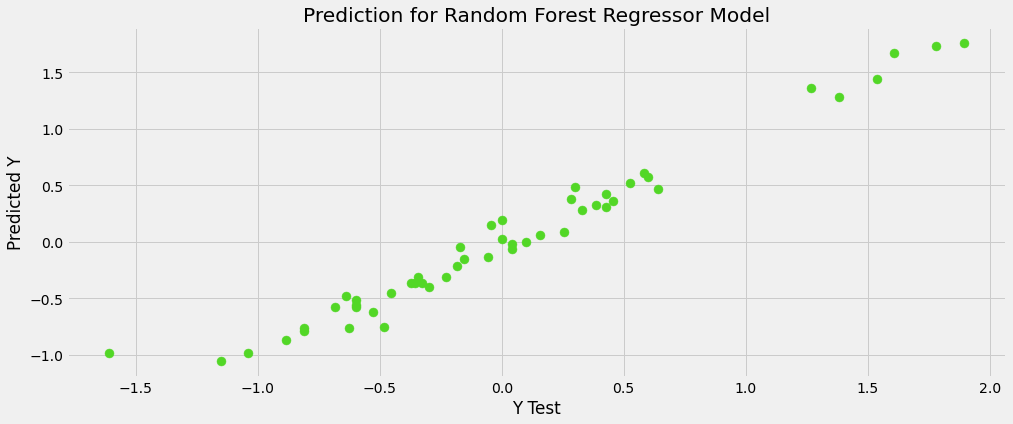

In [50]:
scatter(x_test,y_test,rfr,algo)

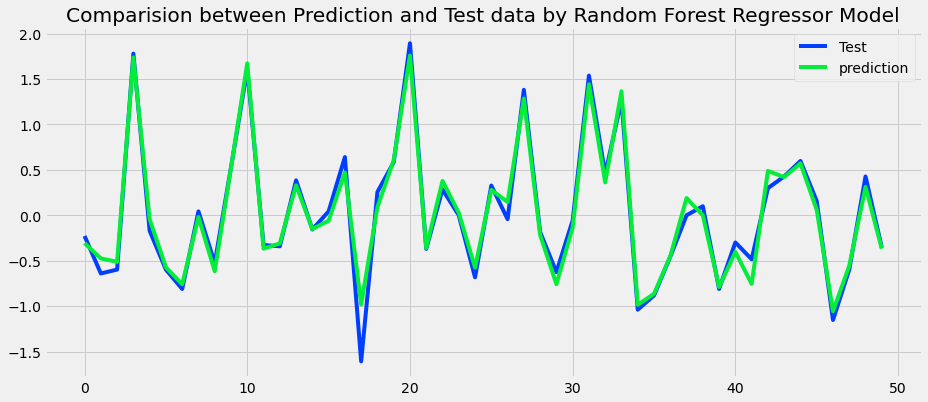

In [51]:
plot(x_test,y_test,rfr,algo)

## Support Vector Regressor

In [54]:
from sklearn.svm import SVR
svr = SVR()
svr.fit(x_train,y_train)
algo= "Support Vector Regressor"
prediction(x_train,x_test,y_train,y_test,svr,algo)

predictions for Support Vector Regressor Algorithem
Train Results: 
        Training R2 Score : 99.04 %

        Training Mean Absolute Error : 0.0560 

        Training Mean Squared Error : 0.0051 


Test Results: 
        Testing R2 Score : 95.93 %

        Testing Mean Absolute Error : 0.0936 

        Testing Mean Squared Error : 0.0232 

        Residual sum of squares: 0.000007


In [55]:
cvs(x,y,svr,algo)

Cross validation Score for Support Vector Regressor : 98.18 %


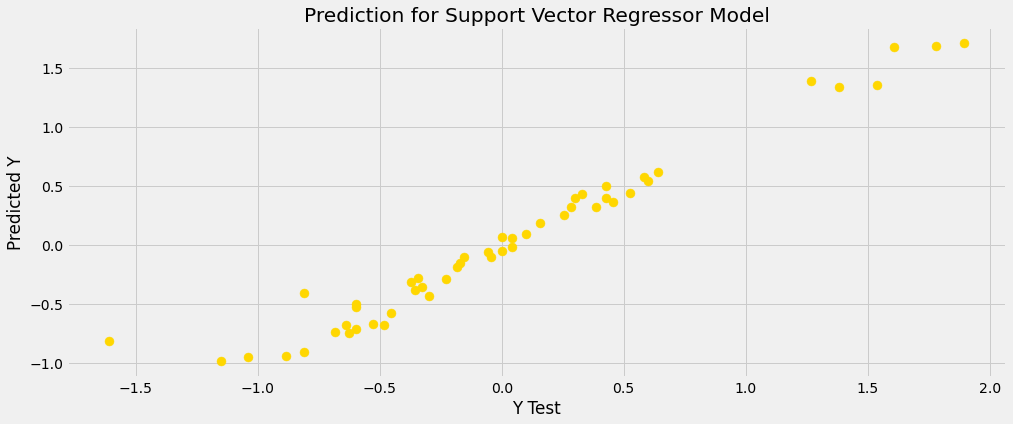

In [56]:
scatter(x_test,y_test,svr,algo)

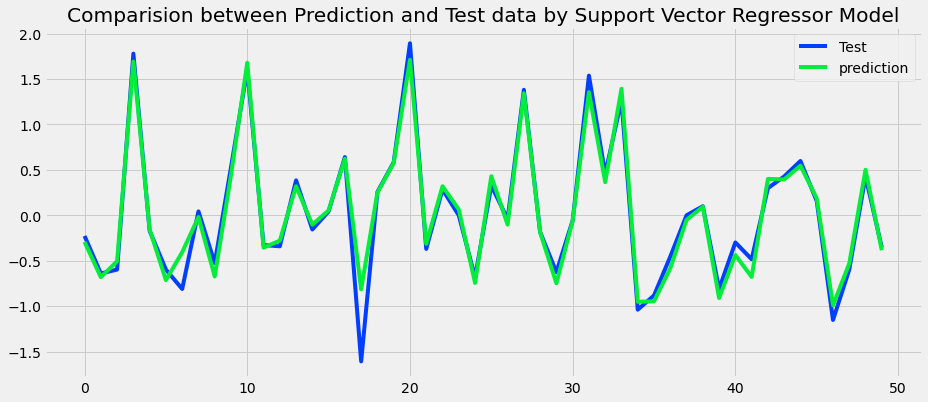

In [57]:
plot(x_test,y_test,svr,algo)

## Comparing the models

In [58]:
results = {"Model":Model,"Testing_R2_Score":Testing_R2_Score,
           "cros_val_scr":cros_val_scr,"Training_MSE":Training_MSE,"Testing_MSE":Testing_MSE,
          "Testing_MAE":Testing_MAE,"Residual_sum_of_squares":Residual_sum_of_squares}

df = pd.concat([pd.Series(v,name=k) for k,v in results.items()],axis=1)
df.set_index("Model",inplace=True)
df

,Testing_R2_Score,cros_val_scr,Training_MSE,Testing_MSE,Testing_MAE,Residual_sum_of_squares
Model,,,,,,
Linear Regression_1,85.80,88.74,0.049,0.081,0.185,0.000263
Linear Regression_2,85.81,88.93,0.049,0.081,0.184,0.000250
Gradient Boosting Regressor,96.68,97.83,0.001,0.019,0.095,0.000006
Ada Boost Regressor,95.03,95.10,0.011,0.028,0.134,0.000315
Random Forest Regressor,96.90,97.79,0.001,0.018,0.092,0.000003
Support Vector Regressor,95.93,98.18,0.005,0.023,0.094,0.000007


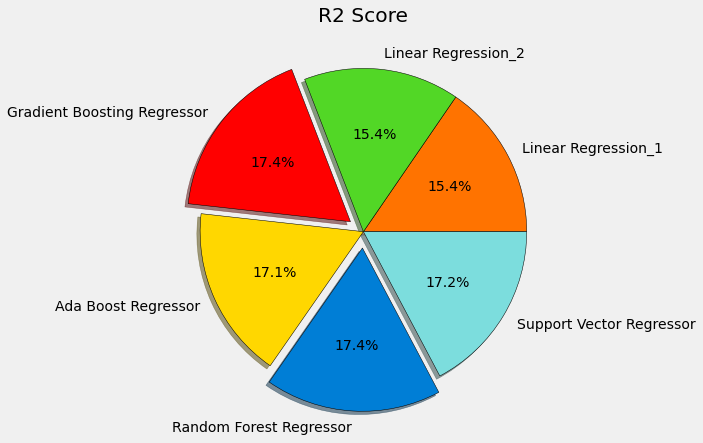

In [59]:
res = []
for i in Testing_R2_Score:
    val = round(i/np.sum(Testing_R2_Score),4)
    res.append(val)

label = [i for i in Model]
color = ["#FF7300","#52D726","#FF0000","gold","#007ED6","#7CDDDD"]
plt.figure(figsize=(12,7))
plt.style.use("fivethirtyeight")
explode = [0.0,0.0,0.1,0.0,0.1,0.0]
plt.pie(res,labels=label,colors=color,explode=explode,autopct="%1.1f%%",
        shadow=True,wedgeprops={"edgecolor":"black"})
plt.title("R2 Score")
plt.show()

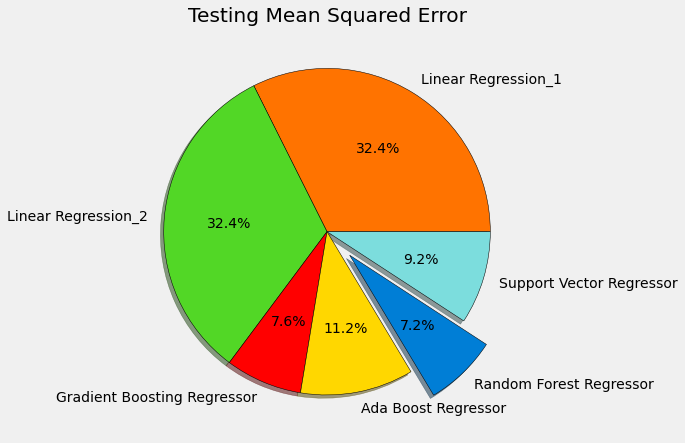

In [60]:
res = []
for i in Testing_MSE:
    val = round(i/np.sum(Testing_MSE),4) 
    res.append(val) 

label = [i for i in Model]
color = ["#FF7300","#52D726","#FF0000","gold","#007ED6","#7CDDDD"]
plt.figure(figsize=(12,7))
plt.style.use("fivethirtyeight")
explode = [0.0,0.0,0.0,0.0,0.2,0.0]
plt.pie(res,labels=label,colors=color,explode=explode,autopct="%1.1f%%",
        shadow=True,wedgeprops={"edgecolor":"black"})
plt.title("Testing Mean Squared Error")
plt.show()

Random Forest Regressor giving less error result comparing to gradient boost regressor &also cross validation score is high,so we took Random Forest Regressor for further steps.

## Hyper parameter tuning 

In [61]:
rfr = RandomForestRegressor()
parameters = {'n_estimators':[20,50,80,100,150], 'min_samples_split':[2,5,6,8,10,12],
              'max_depth':[10,20,25,30,35,40,50],'bootstrap': [True, False],
              'min_samples_leaf': [1,2,3,4,5,6]}
grid = GridSearchCV(rfr,parameters,cv=4,n_jobs=-1)
grid.fit(x_train, y_train)
print ("r2 / variance : ", grid.best_score_)

r2 / variance :  0.9791682407985756


In [62]:
grid.best_params_

{'bootstrap': True,
 'max_depth': 25,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 150}

In [63]:
grid.get_params()

{'cv': 4,
 'error_score': nan,
 'estimator__bootstrap': True,
 'estimator__ccp_alpha': 0.0,
 'estimator__criterion': 'mse',
 'estimator__max_depth': None,
 'estimator__max_features': 'auto',
 'estimator__max_leaf_nodes': None,
 'estimator__max_samples': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_impurity_split': None,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 100,
 'estimator__n_jobs': None,
 'estimator__oob_score': False,
 'estimator__random_state': None,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': RandomForestRegressor(),
 'iid': 'deprecated',
 'n_jobs': -1,
 'param_grid': {'n_estimators': [20, 50, 80, 100, 150],
  'min_samples_split': [2, 5, 6, 8, 10, 12],
  'max_depth': [10, 20, 25, 30, 35, 40, 50],
  'bootstrap': [True, False],
  'min_samples_leaf': [1, 2, 3, 4, 5, 6]},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_s

In [64]:
grid
algo = "Random Forest Regressor HPT"
prediction(x_train,x_test,y_train,y_test,grid,algo)

predictions for Random Forest Regressor HPT Algorithem
Train Results: 
        Training R2 Score : 99.74 %

        Training Mean Absolute Error : 0.0295 

        Training Mean Squared Error : 0.0014 


Test Results: 
        Testing R2 Score : 97.11 %

        Testing Mean Absolute Error : 0.0896 

        Testing Mean Squared Error : 0.0165 

        Residual sum of squares: 0.000031


In [65]:
pre = grid.predict(x_test)

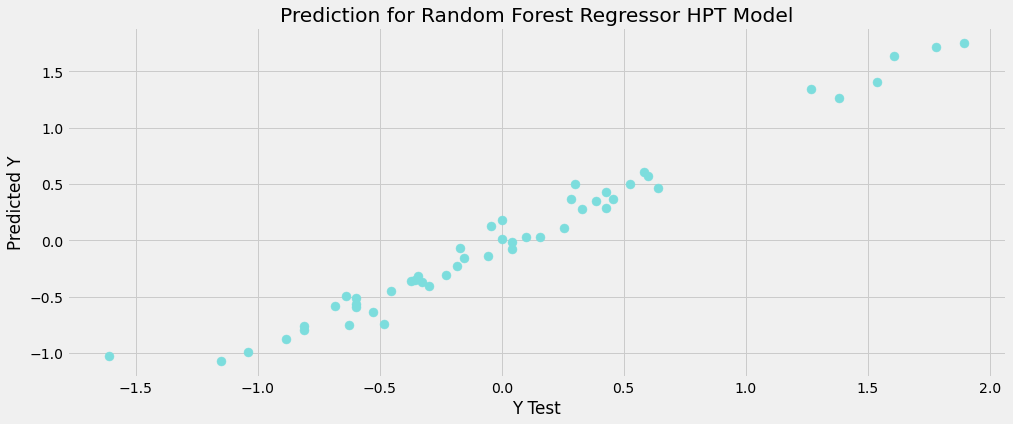

In [70]:
scatter(x_test,y_test,grid,algo)

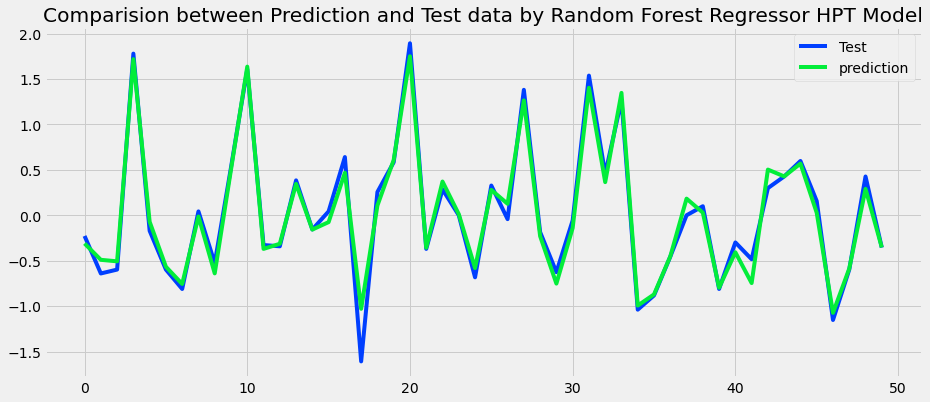

In [71]:
plot(x_test,y_test,grid,algo)

## Evaluation metrics

In [72]:
print(f"Explained Variance Socre : {round(metrics.explained_variance_score(pre,y_test)*100,4)}")
print(f"Max Error                : {metrics.max_error(pre,y_test)}")
print(f"Root Mean Squared Error  : {round(np.sqrt(metrics.mean_squared_error(pre,y_test)),4)}")

Explained Variance Socre : 96.78
Max Error                : 0.5789798339264547
Root Mean Squared Error  : 0.1284


Random forest regressor is given good result compared to other Model.